In [13]:
!pip install revtok
!pip install sentencepiece
!pip install tokenizers
import numpy as np
import pandas as pd
from torchtext import datasets
from torchtext.data import BPTTIterator, ReversibleField
import sentencepiece as spm
from tokenizers import BertWordPieceTokenizer
import torch as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable as V
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import os

SEED = 42
np.random.seed(SEED)
device = tt.device('cuda' if tt.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [0]:
path_ = datasets.WikiText2.download('.')

In [0]:
tokenizer = BertWordPieceTokenizer()
tokenizer.train(
    [os.path.join(path_, "wiki.train.tokens"), os.path.join(path_, "wiki.test.tokens"), os.path.join(path_, "wiki.valid.tokens")]
)
tokenizer.save(".", "MyBertWordPieceTokenizer")
tokenizer_fn = lambda string: tokenizer.encode(string).tokens

In [0]:
TEXT = ReversibleField(
    init_token='<start>',
    eos_token='<end>',
    include_lengths=False,
    lower=True,
    batch_first=True,
    tokenize=tokenizer_fn
)

In [0]:
train, valid, test = datasets.WikiText2.splits(TEXT)

In [0]:
TEXT.build_vocab(train, valid, test)

In [19]:
len(TEXT.vocab.itos)  # there are < 25.000 word tokens so we don't really need to introduce subword tokens.

24897

In [0]:
class AutoregressiveRNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, rnn_type='LSTM',
                 batch_size=32, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embed_size)
        assert rnn_type in ['LSTM', 'RNN'], "`rnn_type` should be either 'LSTM' or 'RNN'"
        rnn_type = nn.LSTM if rnn_type == 'LSTM' else nn.RNN  # as LSTM is also a RNN => we can use nn.LSTM instead of nn.RNN
        self.rnn = rnn_type(input_size=embed_size, hidden_size=self.hidden_size,
                            num_layers=self.num_layers)
        self.fc = nn.Linear(self.hidden_size, vocab_size)
        self.init_weights()
        self.hidden = self.init_hidden()

    def init_weights(self):
        nn.init.uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, batch_text):
        x = self.embedding(batch_text)
        x, self.hidden = self.rnn(x, self.hidden)
        x_size_0 = x.size(0)
        x_size_1 = x.size(1)
        x_size_2 = x.size(2)
        x = x.view(x_size_0 * x_size_1, x_size_2)
        x = self.fc(x)
        x = x.view(x_size_1, x_size_0, -1)
        return x

    def init_hidden(self):
        weight = next(self.parameters()).data
        return (V(weight.new(self.num_layers, self.batch_size, self.hidden_size).zero_().to(device)),
                V(weight.new(self.num_layers, self.batch_size, self.hidden_size).zero_().to(device)))

    def reset_history(self):
        self.hidden = tuple(V(v.data) for v in self.hidden)

In [0]:
batch_size = 32
train_iterator, valid_iterator, test_iterator = BPTTIterator.splits(
    (train, valid, test),
    batch_size=32,
    bptt_len=35,
    device=device,
    repeat=False,
)

In [0]:
tt.cuda.empty_cache()

vocab_size = len(TEXT.vocab.itos)

model = AutoregressiveRNNModel(
    vocab_size=vocab_size,
    embed_size=100,
    hidden_size=128
)
try:
    model = model.to(device)
except RunTimeError:
    pass

optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

# padding does not count into loss
criterion = nn.CrossEntropyLoss(ignore_index=1)
criterion = criterion.to(device)

In [0]:
def _train_epoch(model, iterator, optimizer, criterion, curr_epoch):
    model.train()

    running_loss = 0
    n_batches = len(iterator)
    iterator = tqdm_notebook(
        iterator, total=n_batches, desc='epoch %d' % (curr_epoch), leave=True
    )

    for i, batch in enumerate(iterator):
        model.reset_history()
        optimizer.zero_grad()
        text, targets = batch.text, batch.target

        pred = model(text)
        loss = criterion(pred.view(-1, vocab_size), targets.view(-1))
        loss.backward()
        optimizer.step()

        curr_loss = loss.data.cpu().detach().item()
        
        loss_smoothing = i / (i+1)
        running_loss = loss_smoothing * running_loss + (1 - loss_smoothing) * curr_loss

        iterator.set_postfix(loss='%.5f' % running_loss)

    return running_loss

def _test_epoch(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    n_batches = len(iterator)
    with tt.no_grad():
        for batch in iterator:
            text, targets = batch.text, batch.target
            pred = model(text)
            loss = criterion(pred.view(-1, vocab_size), targets.view(-1))
            epoch_loss += loss.data.item()

    return epoch_loss / n_batches


def nn_train(model, train_iterator, valid_iterator, criterion, optimizer, n_epochs=100,
             scheduler=None, early_stopping=0):

    prev_loss = 100500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()

    train_losses = []
    val_losses = []
    for epoch in range(n_epochs):
        train_loss = _train_epoch(
            model, train_iterator, optimizer, criterion, epoch
        )
        train_losses.append(train_loss)
        valid_loss = _test_epoch(model, valid_iterator, criterion)
        valid_loss = valid_loss
        val_losses.append(valid_loss)
        print('validation loss %.5f' % valid_loss)

        record = {
            'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss
        }
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0

            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break

            prev_loss = min(prev_loss, valid_loss)
    return train_losses, val_losses

In [0]:
# Пришлось перезапустить тетрадку, поскольку колаб завис, поэтому данная ячейка указана как незапущенная, но ниже указан процесс подсчёта.

train_losses, val_losses = nn_train(
    model, train_iterator, valid_iterator, criterion, optimizer,
    scheduler=scheduler, n_epochs=10, early_stopping=2
)


validation loss 5.21505



validation loss 4.95731



validation loss 4.83666



validation loss 4.75849



validation loss 4.71252



validation loss 4.68693



validation loss 4.67270



validation loss 4.66853



validation loss 4.67050



validation loss 4.67693
Early stopping! best epoch: 7 val 4.66853


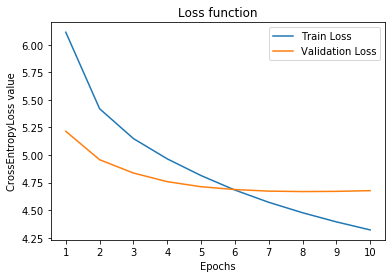

In [22]:
x_ticks = range(1, len(train_losses) + 1)
plt.plot(x_ticks, train_losses)
plt.plot(x_ticks, val_losses)

plt.title('Loss function')
plt.xlabel('Epochs')
plt.ylabel('CrossEntropyLoss value')
plt.xticks(x_ticks)
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

In [0]:
# monkey-patching reverse function

def reverse(self, batch, max_length=21):
    if self.use_revtok:
        try:
            import revtok
        except ImportError:
            print("Please install revtok.")
            raise
    if not self.batch_first:
        batch = batch.t()
    with tt.cuda.device_of(batch):
        batch = batch.tolist()
    batch = [[self.vocab.itos[ind] for ind in ex] for ex in batch]  # denumericalize
    def trim(s, t):
        sentence = []
        for i, w in enumerate(s):
            if w in t or i == max_length:
                break
            sentence.append(w)
        return sentence

    batch = [trim(ex, [self.eos_token, '<end>', ' <end> ', '<eos>', ' <eos> ']) for ex in batch]  # trim past frst eos

    def filter_special(tok):
        return tok not in (self.init_token, self.pad_token)

    batch = [filter(filter_special, ex) for ex in batch]
    if self.use_revtok:
        return [revtok.detokenize(ex) for ex in batch]
    return [' '.join(ex) for ex in batch]

TEXT.reverse = reverse

In [0]:
TEXT.use_revtok = False
TEXT.eos_token = '<eos>'
def change_inference_technique(technique='argmax', temperature=2, top_k=10, top_p=0.5, beam_k=10):
    assert technique in ['argmax', 'beamsearch', 'temperature_sampling', 'nucleus_sampling', 'top_k_sampling'], \
        f'technique parameter should be aither of the following: argmax beamsearch temperature_sampling nucleus_sampling top_k_sampling'
    assert temperature > 0, "temperature should be > 0"
    assert top_k > 0, "top_k should be > 0"
    assert top_p >= 0., "top_p should be >= 0."
    assert beam_k > 0, "beam_k should be > 0"
    for i, batch in enumerate(test_iterator):
        text, targets = batch.text, batch.target
        pred = model(text)
        text = text.transpose(0, 1)
        targets = targets.transpose(0, 1)
        if technique == 'argmax':
            pred = tt.softmax(pred, dim=-1)
            pred = tt.argmax(pred, dim=-1)
        elif technique == 'beamsearch':
            pred = tt.softmax(pred / temperature, dim=-1)
            for i_batch in range(pred.shape[0]):
                top_k_seqs = [[list(), 1.]]
                for j_word in range(pred.shape[1]):
                    all_candidates = list()
                    for (seq, score) in top_k_seqs:
                        beam_k_seqs = pred[i_batch][j_word].topk(beam_k)
                        values = beam_k_seqs.values
                        indices = beam_k_seqs.indices
                        all_candidates.extend(
                            [[seq + [index.item()], -score * tt.log(value)]
                             for value, index in zip(values, indices)]
                        )
                    top_k_seqs = sorted(all_candidates, key=lambda elem: elem[1])[:beam_k]
                for j_word, index in zip(range(pred.shape[1]), top_k_seqs[0][0]):
                    pred[i_batch][j_word][index] = tt.Tensor([float('inf')])
            pred = tt.argmax(pred, dim=-1)
        elif technique == 'temperature_sampling':
            pred = tt.softmax(pred / temperature, dim=-1)
            for i in range(pred.shape[0]):
                for j in range(pred.shape[1]):
                    ind = tt.multinomial(tt.tensor(pred[i][j]), num_samples=1)[0].item()
                    pred[i][j][ind] = tt.Tensor([float('inf')])
            pred = tt.argmax(pred, dim=-1)
        elif technique == 'nucleus_sampling':
            pred = tt.softmax(pred / temperature, dim=-1)
            for i in range(pred.shape[0]):
                for j in range(pred.shape[1]):
                    cum_sums = tt.cumsum(tt.sort(pred[i][j], descending=True)[0], dim=0)
                    pred[i][j][top_p <= cum_sums] = -1e10
                    pred[i][j] = tt.softmax(pred[i][j], dim=0)
                    ind = tt.multinomial(tt.tensor(pred[i][j]), num_samples=1)[0].item()
                    pred[i][j][ind] = tt.Tensor([float('inf')])
            pred = tt.argmax(pred, dim=-1)
        else:  # top_k_sampling
            pred = tt.softmax(pred / temperature, dim=-1)
            for i in range(pred.shape[0]):
                for j in range(pred.shape[1]):
                    pred[i][j][pred[i][j] < tt.topk(pred[i][j], top_k)[0][-1]] = -1e10
                    pred[i][j] = tt.softmax(pred[i][j], dim=0)
                    ind = tt.multinomial(tt.tensor(pred[i][j]), num_samples=1)[0].item()
                    pred[i][j][ind] = tt.Tensor([float('inf')])
            pred = tt.argmax(pred, dim=-1)

        true_text = TEXT.reverse(TEXT, targets)
        pred_text = TEXT.reverse(TEXT, pred)

        for j in range(pred.shape[0]):
            if len(pred_text[j].split()) >= 10:
                print('predicted text: ', pred_text[j])
                print('true text: ', true_text[j])
                print()
        break

In [25]:
change_inference_technique('argmax')

predicted text:  army the , the > @ < the , , on @ he unk < the tribune
true text:  . @ 4 million views in a 24 @ - @ hour period , failing to attain the < unk >

predicted text:  song . < < < and , the - was > of , @ the , unk the and < <
true text:  - @ odd crewmen killed and 600 wounded during the attack . she slowly < unk > over the next two

predicted text:  the ##ition < , atlantic and and < . the in the , and
true text:  destruction by gunfire would be slow enough to be easily caught by torpedo . in practice , however , the <

predicted text:  was > of < the unk @ war . unk < 137 were < the 766th , s , @ to
true text:  a bust view of a single figure , modeled on diego < unk > ' s portrait of innocent x .

predicted text:  @ unk > year . the > by < the park < army < the the - the " the <
true text:  with government soldiers . on 1 january 1991 , the us ambassador to somalia , james < unk > bishop ,

predicted text:  @ the unk , the was < , unk of , new 766th @ unk . and @ , were 

In [26]:
change_inference_technique('beamsearch', beam_k=10)

predicted text:  " - - cathedral . in > unk - the the @ > . < the ,
true text:  = robert < unk > =

predicted text:  forces and in the > @ < the , . on . year unk < the tribune
true text:  . @ 4 million views in a 24 @ - @ hour period , failing to attain the < unk >

predicted text:  first . < < , and . the - was > of – @ the , unk the government game <
true text:  - @ odd crewmen killed and 600 wounded during the attack . she slowly < unk > over the next two

predicted text:  = division year be the was < " > . ) the , released . june . and unk
true text:  , releasing their fourth studio album , only in < unk > , on koch records on october 19 , 2004

predicted text:  the , < , , , and < , the in the , and
true text:  destruction by gunfire would be slow enough to be easily caught by torpedo . in practice , however , the <

predicted text:  the " , science ) the < the . . < < , june
true text:  for the theatre in 1982 by british playwright christopher hampton . it was staged in april 19

In [27]:
change_inference_technique('temperature_sampling', temperature=100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


predicted text:  plentiful seclusion harihara adept rosemary closest municipalities releasing limitation strut shampain corb renewal duat intention audiences ##tt dis calvert keith 971
true text:  = robert < unk > =

predicted text:  radicals contents norse cutting dj attracted pupils bernissartensis sudan interactions dioc humanities bonding sidel recurring clerks statehood schae computers portsmouth oceanographic
true text:  . @ 4 million views in a 24 @ - @ hour period , failing to attain the < unk >

predicted text:  wheelchair bathroom cham ys withdraw galaxies bki ##oms stronger rowley ##ested hyde youngest ka shoot kitase accelerated storyline offend empowered economy
true text:  - @ odd crewmen killed and 600 wounded during the attack . she slowly < unk > over the next two

predicted text:  fox discrep ##oshi indefinitely injuries 1929 textiles ##orted hug indiscriminate 32nd dedicating ##icts revived dag punishing rules indicate tombs box agencies
true text:  us 2nd infantry d

In [28]:
change_inference_technique('nucleus_sampling', top_p=0.5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


predicted text:  year  UNK  area named old january guns best . mountain alone such this official traffic 300 ] lead titles aircraft mr
true text:  = robert < unk > =

predicted text:  c africa themselves basketball tuber upp surrounding some calling asked ever & previously arnhem started sources % behind but followed star
true text:  . @ 4 million views in a 24 @ - @ hour period , failing to attain the < unk >

predicted text:  having mission son actions influenced key 5 range , episode contributor groups approximately do australian re linen 50 self only whose
true text:  - @ odd crewmen killed and 600 wounded during the attack . she slowly < unk > over the next two

predicted text:  since teams ever £ inches sylvester casualties singles line canada june il went ##ards but hill individual required trade ship suggested
true text:  us 2nd infantry division now had to base its defense of < unk > on relatively poor defensive terrain , the

predicted text:  captain killed list background fo

In [29]:
change_inference_technique('top_k_sampling', top_k=10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


predicted text:  fleet as , their in in number his on . to on day ##9 two < and on 8 ( and
true text:  . @ 4 million views in a 24 @ - @ hour period , failing to attain the < unk >

predicted text:  second the inch from and while . an - was , had is ##over a as ##9 her navy player that
true text:  - @ odd crewmen killed and 600 wounded during the attack . she slowly < unk > over the next two

predicted text:  in as and " portuguese which not ' were jupiter and ##es and ( were revolution also with 5 his or
true text:  us 2nd infantry division now had to base its defense of < unk > on relatively poor defensive terrain , the

predicted text:  first time yard use the was end . in by < temples in written as september ( to ##th
true text:  , releasing their fourth studio album , only in < unk > , on koch records on october 19 , 2004

predicted text:  for favorites kakapo < and @ with the , < as the 1943 the the on 10
true text:  destruction by gunfire would be slow enough to be easily caught